<a href="https://colab.research.google.com/github/MuhammadBayuNugroho/analisis-sentimen-artikel/blob/main/Baru_of_07_FIKS_Random_Oversampling_Analisis_Sentimen_IndoBERT_dan_DeBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ALGORITMA INDOBERT DAN DEBERTA DENGAN RANDOM OVERSAMPLING**

# Import Library yang dibutuhkan.

In [ ]:
!pip install transformers==4.31.0
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.31.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import library pandas untuk manipulasi dan analisis data
import pandas as pd
# Import library numpy untuk operasi numerik
import numpy as np

# Import library train_test_split untuk membagi dataset menjadi data train dan test
from sklearn.model_selection import train_test_split
# Import library compute_class_weight untuk menghitung bobot kelas dalam dataset yang tidak seimbang
from sklearn.utils.class_weight import compute_class_weight
# Import library Counter untuk menghitung distribusi kelas
from collections import Counter

# Import library matplotlib.pyplot untuk membuat visualisasi data
import matplotlib.pyplot as plt
# Import library torch untuk operasi tensor dan deep learning
import torch
# Import library DataLoader dan Dataset untuk mempersiapkan pipeline data dalam PyTorch
from torch.utils.data import DataLoader, Dataset

# Import library BertTokenizer dan BertForSequenceClassification untuk menggunakan model IndoBERT
from transformers import BertTokenizer, BertForSequenceClassification
# Import library DebertaV2Tokenizer dan DebertaV2ForSequenceClassification untuk menggunakan model DeBERTa
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
# Import library AdamW untuk optimasi model deep learning
from transformers import AdamW

# Import library classification_report dan confusion_matrix untuk evaluasi performa model
from sklearn.metrics import classification_report, confusion_matrix
# Nilai akurasi, presisi, recall, dan f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import time
from sklearn.model_selection import StratifiedKFold

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Memuat dataset dari google drive
file_path = '/content/drive/MyDrive/Dataset Analisis Sentimen/Baru - Hasil EDA Preprocessing 3.csv'
dataset = pd.read_csv(file_path)

# Menampilkan informasi umum dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Cleaned Comment    1711 non-null   object
 1   Revised_Sentiment  1711 non-null   object
dtypes: object(2)
memory usage: 26.9+ KB


In [ ]:
# ubah nama kolom
dataset = dataset.rename(columns={'Revised_Sentiment': 'Sentiment'})
dataset.head()

,Cleaned Comment,Sentiment
0,baterai mahal,negative
1,subsidi mobil listrik orang kaya guys kalau ba...,neutral
2,hemat listrik mobil pakai panel sorya solusinya,neutral
3,mahal ciptain mesin listrik,negative
4,regulasi safetynya gak bahas parkir garasi rum...,positive


# Analisis Distribusi Sentimen

Distribusi Sentimen Sebelum Oversampling:
Sentiment
positive    1013
negative     488
neutral      210
Name: count, dtype: int64


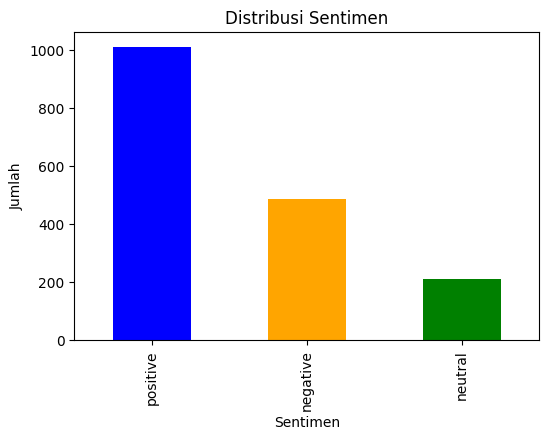

In [ ]:
# Distribusi Sentimen
def plot_sentiment_distribution(y):
    counts = y.value_counts()
    counts.plot(kind='bar', color=['blue', 'orange', 'green'], figsize=(6, 4))
    plt.title("Distribusi Sentimen")
    plt.xlabel("Sentimen")
    plt.ylabel("Jumlah")
    plt.show()

print("Distribusi Sentimen Sebelum Oversampling:")
print(dataset['Sentiment'].value_counts())
plot_sentiment_distribution(dataset['Sentiment'])

In [ ]:
# 2. Frekuensi Kata
positive_texts = dataset[dataset['Sentiment'] == 'positive']['Cleaned Comment']
negative_texts = dataset[dataset['Sentiment'] == 'negative']['Cleaned Comment']
neutral_texts = dataset[dataset['Sentiment'] == 'neutral']['Cleaned Comment']

positive_words = Counter(" ".join(positive_texts).split())
negative_words = Counter(" ".join(negative_texts).split())
neutral_words = Counter(" ".join(neutral_texts).split())

print("\nKata Paling Sering pada Sentimen Positif:")
print(positive_words.most_common(10))

print("\nKata Paling Sering pada Sentimen Negatif:")
print(negative_words.most_common(10))

print("\nKata Paling Sering pada Sentimen Netral:")
print(neutral_words.most_common(10))


Kata Paling Sering pada Sentimen Positif:
[('mobil', 945), ('listrik', 735), ('harga', 414), ('ev', 408), ('beli', 318), ('murah', 309), ('kendara', 189), ('baterai', 174), ('jual', 174), ('indonesia', 170)]

Kata Paling Sering pada Sentimen Negatif:
[('mobil', 322), ('mahal', 302), ('listrik', 266), ('harga', 200), ('beli', 121), ('baterai', 101), ('ev', 93), ('motor', 58), ('gak', 57), ('orang', 54)]

Kata Paling Sering pada Sentimen Netral:
[('mobil', 116), ('mending', 114), ('beli', 88), ('listrik', 73), ('moga', 59), ('ev', 53), ('harga', 46), ('subsidi', 40), ('kalo', 34), ('kendara', 30)]


# Random Oversampling


Distribusi Sentimen Setelah Oversampling:
Counter({2: 810, 0: 810, 1: 810})


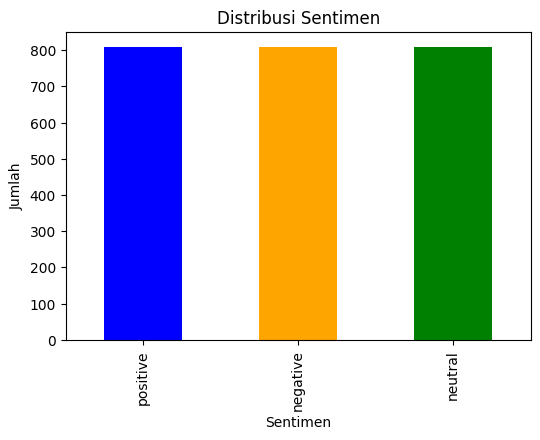

In [ ]:
# ===================== RANDOM OVERSAMPLING =====================

# Import library RandomOverSampler untuk melakukan oversampling
from imblearn.over_sampling import RandomOverSampler

# Encode labels
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
dataset['label'] = dataset['Sentiment'].map(label_mapping)

# Split dataset
X = dataset['Cleaned Comment']
y = dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_frame(), y_train)

# Convert resampled data back to Series format
X_train_resampled = X_train_resampled['Cleaned Comment']

# Distribusi setelah oversampling
print("\nDistribusi Sentimen Setelah Oversampling:")
print(Counter(y_train_resampled))
plot_sentiment_distribution(pd.Series(y_train_resampled).map({v: k for k, v in label_mapping.items()}))



# Tokenizer dan Kelas Dataset

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
# Tampilkan dataset hasil random oversampling
dataset_resampled = pd.DataFrame({'Cleaned Comment': X_train_resampled, 'label': y_train_resampled})
dataset_resampled


,Cleaned Comment,label
0,mantap jokowi sasar,2
1,analogi plts mobil ev pln mobil bbm instalasi ...,2
2,mahal inti,0
3,tpi ngk bisaa prgi jauhhh ngk bisaa k datar ba...,0
4,bismilah moga kebel mobil,1
...,...,...
2425,mantaaps banng bom kayak yangg bahas mobil sec...,1
2426,om ridwan bikin konten rekomendasi mobil range...,1
2427,kalo mikir harga jual mending gak beli mobil jir,1
2428,ko lung kalo duit lu udh unlimited bli mobil l...,1


In [ ]:
# simpan hasil randomoversamlping menjadi dataset baru
dataset_resampled.to_csv('dataset_resampled.csv', index=False)

# Implementasi dengan K-Fold

## IndoBERT

In [ ]:
# Load IndoBERT tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Menyimpan prediksi dan label dari semua fold
all_y_true = []
all_y_pred = []

k_folds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=0)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
    print(f"\n====== Fold {fold + 1} ======")

    # Split data untuk fold ini
    X_train_fold = X_train_resampled.iloc[train_idx].tolist()
    y_train_fold = y_train_resampled.iloc[train_idx].tolist()
    X_val_fold = X_train_resampled.iloc[val_idx].tolist()
    y_val_fold = y_train_resampled.iloc[val_idx].tolist()

    # Dataset & Dataloader
    train_dataset = SentimentDataset(X_train_fold, y_train_fold, tokenizer)
    val_dataset = SentimentDataset(X_val_fold, y_val_fold, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Load model IndoBERT
    model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
    model.to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # 8. TRAINING LOOP
    model.train()
    for epoch in range(5):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

    # 9. EVALUASI MODEL DI VALIDATION SET
    model.eval()
    y_true_indobert, y_pred_indobert = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            y_true_indobert.extend(labels.cpu().numpy())
            y_pred_indobert.extend(predictions.cpu().numpy())

    # Tambahkan hasil ke list global
    all_y_true.extend(y_true_indobert)
    all_y_pred.extend(y_pred_indobert)

    # 10. HITUNG METRIK
    acc = accuracy_score(y_true_indobert, y_pred_indobert)
    prec = precision_score(y_true_indobert, y_pred_indobert, average='macro', zero_division=0)
    rec = recall_score(y_true_indobert, y_pred_indobert, average='macro', zero_division=0)
    f1 = f1_score(y_true_indobert, y_pred_indobert, average='macro', zero_division=0)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")

    fold_results.append({
        'fold': fold + 1,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

# 11. RATA-RATA HASIL SEMUA FOLD
results_df = pd.DataFrame(fold_results)
print("\n====== RATA-RATA 5-FOLD CROSS VALIDATION ======")
print(results_df.mean(numeric_only=True))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]


====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 0.5210
Epoch 2 - Loss: 0.1312
Epoch 3 - Loss: 0.0579
Epoch 4 - Loss: 0.0336
Epoch 5 - Loss: 0.0294
Accuracy : 0.9630
Precision: 0.9637
Recall   : 0.9630
F1-Score : 0.9629

====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 0.4966
Epoch 2 - Loss: 0.1335
Epoch 3 - Loss: 0.0536
Epoch 4 - Loss: 0.0347
Epoch 5 - Loss: 0.0191
Accuracy : 0.9733
Precision: 0.9732
Recall   : 0.9733
F1-Score : 0.9732

====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 0.5409
Epoch 2 - Loss: 0.1320
Epoch 3 - Loss: 0.0568
Epoch 4 - Loss: 0.0446
Epoch 5 - Loss: 0.0387
Accuracy : 0.9527
Precision: 0.9527
Recall   : 0.9527
F1-Score : 0.9523

====== Fold 4 ======


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 0.5177
Epoch 2 - Loss: 0.1513
Epoch 3 - Loss: 0.0562
Epoch 4 - Loss: 0.0359
Epoch 5 - Loss: 0.0160
Accuracy : 0.9568
Precision: 0.9601
Recall   : 0.9568
F1-Score : 0.9564

====== Fold 5 ======


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 0.4920
Epoch 2 - Loss: 0.1025
Epoch 3 - Loss: 0.0477
Epoch 4 - Loss: 0.0139
Epoch 5 - Loss: 0.0060
Accuracy : 0.9609
Precision: 0.9613
Recall   : 0.9609
F1-Score : 0.9609

====== RATA-RATA 5-FOLD CROSS VALIDATION ======
fold         3.000000
accuracy     0.961317
precision    0.962199
recall       0.961317
f1           0.961154
dtype: float64



====== CLASSIFICATION REPORT DARI SELURUH FOLD ======
              precision    recall  f1-score   support

    negative       0.95      0.96      0.95       810
     neutral       0.98      0.99      0.98       810
    positive       0.96      0.93      0.95       810

    accuracy                           0.96      2430
   macro avg       0.96      0.96      0.96      2430
weighted avg       0.96      0.96      0.96      2430



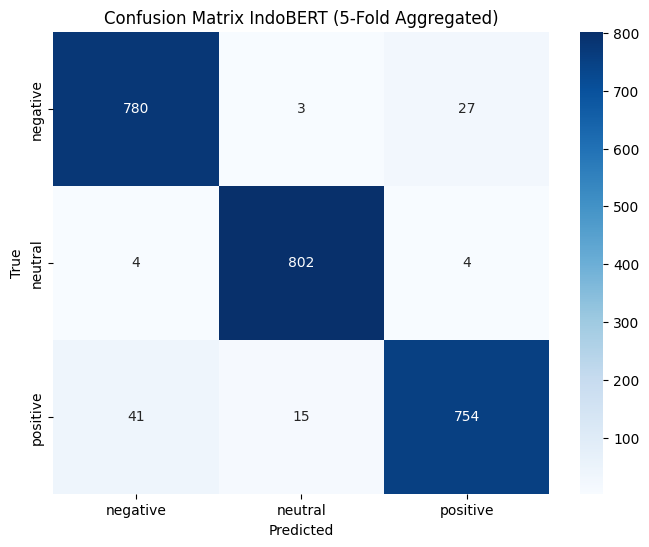

In [ ]:
# Classification Report dari seluruh fold
print("\n====== CLASSIFICATION REPORT DARI SELURUH FOLD ======")
print(classification_report(all_y_true, all_y_pred, target_names=label_mapping.keys()))

# Confusion Matrix dari seluruh fold
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix IndoBERT (5-Fold Aggregated)')
plt.show()

## Deberta B16

In [ ]:
# Load tokenizer dan setup
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-small")
k_folds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

# Simpan semua prediksi dan label untuk klasifikasi agregat
all_y_true_deberta = []
all_y_pred_deberta = []

# Start training
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
    print(f"\n====== Fold {fold + 1} ======")

    # Split data
    X_train_fold = X_train_resampled.iloc[train_idx].tolist()
    y_train_fold = y_train_resampled.iloc[train_idx].tolist()
    X_val_fold = X_train_resampled.iloc[val_idx].tolist()
    y_val_fold = y_train_resampled.iloc[val_idx].tolist()

    # Dataset & Dataloader
    train_dataset = SentimentDataset(X_train_fold, y_train_fold, tokenizer)
    val_dataset = SentimentDataset(X_val_fold, y_val_fold, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Load DeBERTa model
    model = DebertaV2ForSequenceClassification.from_pretrained(
        "microsoft/deberta-v3-small", num_labels=3
    )
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=1e-5)

    # Training
    model.train()
    for epoch in range(5):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    y_true_deberta, y_pred_deberta = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            y_true_deberta.extend(labels.cpu().numpy())
            y_pred_deberta.extend(predictions.cpu().numpy())

    # Simpan per fold dan gabungkan semua hasil
    all_y_true_deberta.extend(y_true_deberta)
    all_y_pred_deberta.extend(y_pred_deberta)

    # Metrics per fold
    acc = accuracy_score(y_true_deberta, y_pred_deberta)
    prec = precision_score(y_true_deberta, y_pred_deberta, average='macro', zero_division=0)
    rec = recall_score(y_true_deberta, y_pred_deberta, average='macro', zero_division=0)
    f1 = f1_score(y_true_deberta, y_pred_deberta, average='macro', zero_division=0)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")

    fold_results.append({'fold': fold+1, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})

# Rata-rata 5 Fold
results_df = pd.DataFrame(fold_results)
print("\n====== RATA-RATA 5-FOLD CROSS VALIDATION (DeBERTa) ======")
print(results_df.mean(numeric_only=True))




/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



====== Fold 1 ======


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 1.0950
Epoch 2 - Loss: 0.8570
Epoch 3 - Loss: 0.4531
Epoch 4 - Loss: 0.2703
Epoch 5 - Loss: 0.1701
Accuracy : 0.9342
Precision: 0.9345
Recall   : 0.9342
F1-Score : 0.9337

====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 1.0929
Epoch 2 - Loss: 0.6994
Epoch 3 - Loss: 0.3628
Epoch 4 - Loss: 0.2092
Epoch 5 - Loss: 0.1556
Accuracy : 0.9321
Precision: 0.9327
Recall   : 0.9321
F1-Score : 0.9323

====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 1.0961
Epoch 2 - Loss: 0.8261
Epoch 3 - Loss: 0.4225
Epoch 4 - Loss: 0.2633
Epoch 5 - Loss: 0.1787
Accuracy : 0.9403
Precision: 0.9401
Recall   : 0.9403
F1-Score : 0.9401

====== Fold 4 ======


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 1.0934
Epoch 2 - Loss: 0.8078
Epoch 3 - Loss: 0.3849
Epoch 4 - Loss: 0.2467
Epoch 5 - Loss: 0.1548
Accuracy : 0.9300
Precision: 0.9337
Recall   : 0.9300
F1-Score : 0.9290

====== Fold 5 ======


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 1.0921
Epoch 2 - Loss: 0.7032
Epoch 3 - Loss: 0.3935
Epoch 4 - Loss: 0.2741
Epoch 5 - Loss: 0.1770
Accuracy : 0.9198
Precision: 0.9278
Recall   : 0.9198
F1-Score : 0.9194

====== RATA-RATA 5-FOLD CROSS VALIDATION (DeBERTa) ======
fold         3.000000
accuracy     0.931276
precision    0.933755
recall       0.931276
f1           0.930893
dtype: float64



Classification Report (Agregat):
              precision    recall  f1-score   support

    negative       0.90      0.95      0.92       810
     neutral       0.96      0.97      0.96       810
    positive       0.94      0.87      0.90       810

    accuracy                           0.93      2430
   macro avg       0.93      0.93      0.93      2430
weighted avg       0.93      0.93      0.93      2430



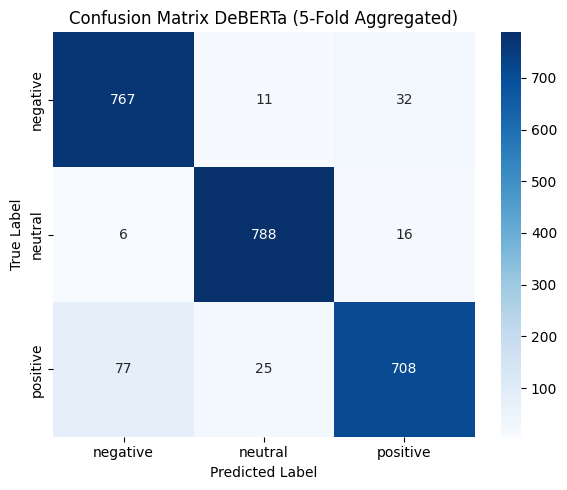

In [ ]:
# Classification Report Agregat
import seaborn as sns
import matplotlib.pyplot as plt
print("\nClassification Report (Agregat):")
print(classification_report(all_y_true_deberta, all_y_pred_deberta, target_names=label_mapping.keys()))

# Confusion Matrix Agregat
cm = confusion_matrix(all_y_true_deberta, all_y_pred_deberta)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.keys(),
            yticklabels=label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix DeBERTa (5-Fold Aggregated)')
plt.tight_layout()
plt.show()